In [13]:
#########################
## Dataset preparation ##
#########################

from torch_geometric.datasets import  Planetoid
from torch_geometric.transforms import NormalizeFeatures

root_path = '/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch/05_GNN/data'

#---------
## Load the dataset
#---------

cora = Planetoid(root=root_path, name="Cora", transform=NormalizeFeatures())

'''
Planetoid is not a single dataset, but rather a collection of three citation network datasets, 
commonly used for benchmarking Graph Neural Networks (GNNs).

########################################

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. 
Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. 
The dictionary consists of 1433 unique words.

Nodes = Publications (Papers, Books ...)
Edges = Citations
Node Features = word vectors
7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, Probabilistic_Methods...
We normalize the features using torch geometric's transform functions.
'''
print()

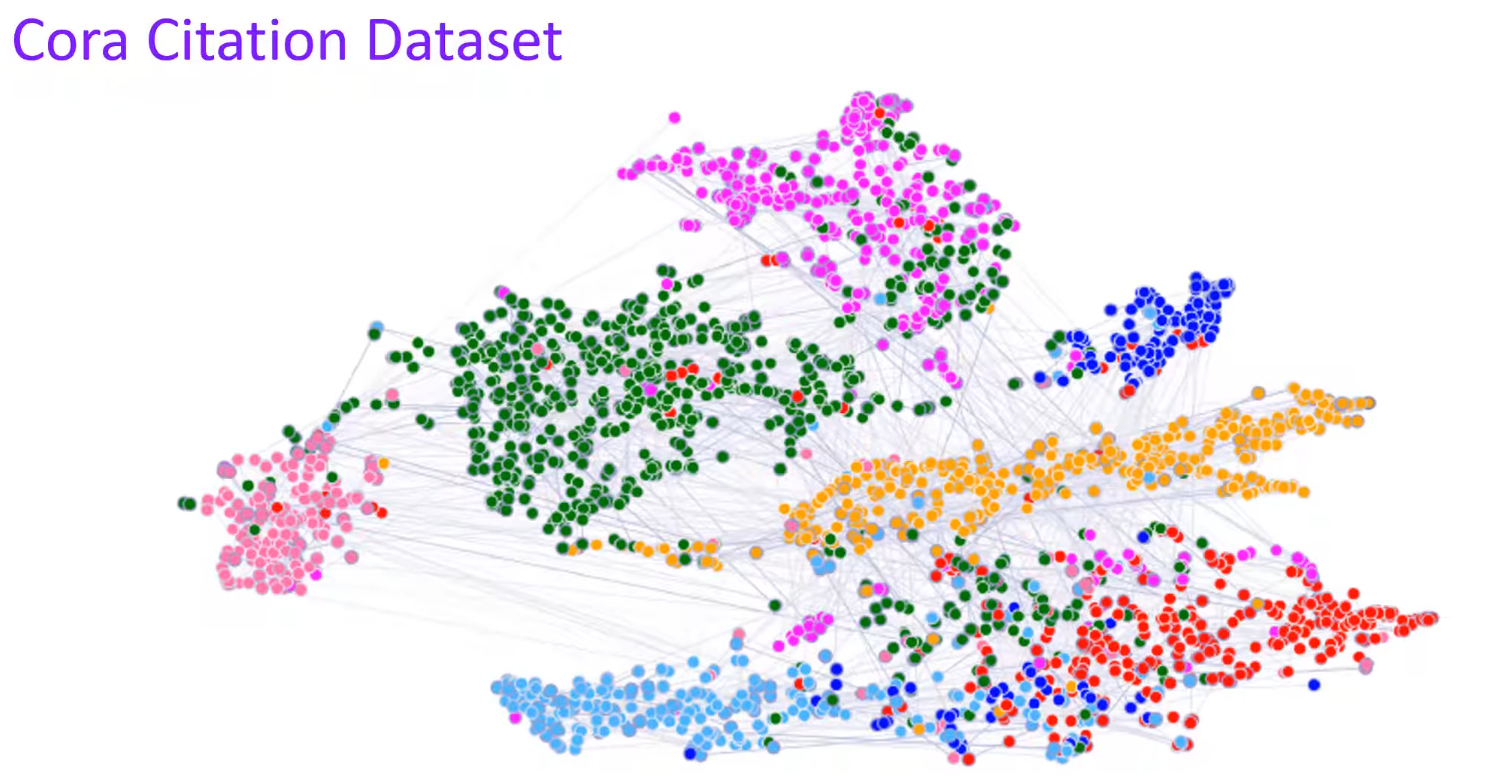

In [14]:
#---------
## Dataset properties
#---------

print(cora) # Cora()
print("number of graphs:\t\t", len(cora))                      # 1 (has only one giant graph)
print("number of classes:\t\t", cora.num_classes)              # 7 (has 7 different features)
print("number of node features:\t", cora.num_node_features)    # 1433 (each node has 1433 features, a bag of 1433 words)
print("number of edge features:\t", cora.num_edge_features)    # 0

Cora()
number of graphs:		 1
number of classes:		 7
number of node features:	 1433
number of edge features:	 0


In [16]:
#---------
## dataset._data
#---------

print(cora._data)
print("\n")
# Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
'''
2708 nodes (papers)
10,556 edges (citations)
1433 features (a bag of 1433 words)
7 classes (research topics)
'''

print("edge_index:\t\t", cora._data.edge_index.shape)
print(cora._data.edge_index)
print("\n")
# edge_index:		 torch.Size([2, 10556])              10556 edges (citation relationships)
# tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],    SOURCE NODES
#         [   0,    0,    0,  ..., 2707, 2707, 2707]])   TARGET NODES
# Example: 633 -> 0, 1862 -> 0

print("train_mask:\t\t", cora._data.train_mask.shape)
print(cora._data.train_mask)
print("\n")
# train_mask:		 torch.Size([2708])
# tensor([ True,  True,  True,  ..., False, False, False])
# True: this is from the training set
# False: this is NOT in the training set

print("X:\t\t", cora._data.x.shape)
print(cora._data.x)
print("\n")
# X:		 torch.Size([2708, 1433])
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# Each row represents one node
# Each column represents one feature of a node

print("y:\t\t", cora._data.y.shape)
print(cora._data.y)
print("\n")
# y:		 torch.Size([2708])
# tensor([3, 4, 4,  ..., 3, 3, 3])
# The output label of each node (in this example, we have 7 different classes)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


edge_index:		 torch.Size([2, 10556])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


X:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])




In [17]:
#----
## get the data
#----

data = cora[0] # Since we have only one dataset, use [0] to get it out

In [19]:
################
## Simple GNN ##
################

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv # GraphSAGE Convolution layer from PyTorch Geometric

'''
What is SAGEConv?
GraphSAGE (SAmple and aggreGatE) is a type of graph convolution that:
# Samples neighbors of each node
# Aggregates their features
# Combines with the node's own features

What happens inside SAGEConv:
For each node i:
# Gather features from neighbors: {x_j : j ∈ Neighbors(i)}
# Aggregate: h_neighbors = max(x_j for all neighbors j) (element-wise max)
# Combine: h_i = W * concat([x_i, h_neighbors])

############ Example #############

x_i = [1, 0, 1]

neighbor_1 = [1, 2, 1]
neighbor_2 = [3, 4, 2]
neighbor_3 = [8, 1, 0]

aggregated = [max(1, 3, 8),   # position 0
              max(2, 4, 1),   # position 1
              max(1, 2, 0)]   # position 2

aggregated = [8, 4, 2]  ✅

=> concat([x_i, aggregated]) = [1, 0, 1, 8, 4, 2]
```

---

## Visual Representation
```
Position:       0   1   2
              ┌───┬───┬───┐
Neighbor 1:   │ 1 │ 2 │ 1 │
              ├───┼───┼───┤
Neighbor 2:   │ 3 │ 4 │ 2 │
              ├───┼───┼───┤
Neighbor 3:   │ 8 │ 1 │ 0 │
              ├───┼───┼───┤
              │ ↓ │ ↓ │ ↓ │
              ├───┼───┼───┤
Max:          │ 8 │ 4 │ 2 │
              └───┴───┴───┘
              
Node's own features:     [1, 0, 1]
                             +
Aggregated neighbors:    [8, 4, 2]
                              ↓
Concatenated:            [1, 0, 1, 8, 4, 2]
                         └─────┘ └───────┘
                          self   neighbors
'''

#----
## build model
#----

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()

        torch.manual_seed(42)
        
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr="mean")
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr="mean")
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training) # Only apply dropout while training, to avoid losing information while inferencing
        
        # Second layer
        x = self.conv2(x, edge_index)

        '''SAGEConv already does linear transformation so we don't need to add a linear layer'''
        return x # Return raw logits for CrossEntropyLoss

# Usage
model = GNN(
    in_channels=cora.num_features,  # 1433
    hidden_channels=16,  # typical choice for Cora
    out_channels=cora.num_classes,  # 7
    dropout=0.5
)

print(model)

GNN(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)


In [20]:
################################
## Optimizer, Loss, Scheduler ##
################################

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model, data = model.to(device), data.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
'''
# With weight_decay:
loss = original_loss + (weight_decay / 2) * sum(param^2 for all params)
=> a regularization technique that prevents overfitting by penalizing large weights.
'''

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=50)

In [ ]:
##############
## Training ##
##############

best_val_acc = test_acc = 0

for epoch in range(1, 101, 1):
    #----TRAIN
    _ = model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()
    
    #-----VAL - TEST
    _ = model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
        
    _, val_acc, tmp_test_acc = accs
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        
    if (epoch % 10 == 0) or (epoch == 1):
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Val: {best_val_acc:.4f}")
        print(f"Test: {test_acc:.4f}")

2026-01-09 13:56:53.950 | INFO     | __main__:<module>:26 - ++++++++++++++++++++++++++++++++++++++++++++++++++
2026-01-09 13:56:53.950 | INFO     | __main__:<module>:27 - Epoch: 1
2026-01-09 13:56:53.950 | INFO     | __main__:<module>:28 - Val: 0.4380
2026-01-09 13:56:53.951 | INFO     | __main__:<module>:29 - Test: 0.4330
2026-01-09 13:56:53.969 | INFO     | __main__:<module>:26 - ++++++++++++++++++++++++++++++++++++++++++++++++++
2026-01-09 13:56:53.969 | INFO     | __main__:<module>:27 - Epoch: 10
2026-01-09 13:56:53.969 | INFO     | __main__:<module>:28 - Val: 0.7260
2026-01-09 13:56:53.969 | INFO     | __main__:<module>:29 - Test: 0.7180
2026-01-09 13:56:53.990 | INFO     | __main__:<module>:26 - ++++++++++++++++++++++++++++++++++++++++++++++++++
2026-01-09 13:56:53.990 | INFO     | __main__:<module>:27 - Epoch: 20
2026-01-09 13:56:53.990 | INFO     | __main__:<module>:28 - Val: 0.7260
2026-01-09 13:56:53.991 | INFO     | __main__:<module>:29 - Test: 0.7180
2026-01-09 13:56:54.011